# Titanic Classification Model

**Notebook by:  Steven Yan, Flatiron School Data Science Immersive Online**

**Instructors:  Fangfang Lee, Justin Tannenbaum**

**Completed as Phase 3 Project Follow-up**

In [227]:
# # reload file with functions
# %load_ext autoreload
# %autoreload 2

import numpy as np 
import pandas as pd
import re

from matplotlib import pyplot as plt
from matplotlib import style
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
 
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, BaggingClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, roc_auc_score, classification_report, plot_confusion_matrix, auc
from sklearn.metrics import mean_squared_error, confusion_matrix, precision_score, recall_score, accuracy_score, f1_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
from xgboost.sklearn import XGBClassifier

def accuracy(y, y_hat):
    y_y_hat = list(zip(y, y_hat))
    tp = sum([1 for i in y_y_hat if i[0] == 1 and i[1] == 1])
    tn = sum([1 for i in y_y_hat if i[0] == 0 and i[1] == 0])
    return (tp + tn) / float(len(y_y_hat))

def f1(y, y_hat):
    precision_score = precision(y, y_hat)
    recall_score = recall(y, y_hat)
    numerator = precision_score * recall_score
    denominator = precision_score + recall_score
    return 2 * (numerator / denominator)

def precision(y, y_hat):
    y_y_hat = list(zip(y, y_hat))
    tp = sum([1 for i in y_y_hat if i[0] == 1 and i[1] == 1])
    fp = sum([1 for i in y_y_hat if i[0] == 0 and i[1] == 1])
    return tp / float(tp + fp)

def recall(y, y_hat):
    # Your code here
    y_y_hat = list(zip(y, y_hat))
    tp = sum([1 for i in y_y_hat if i[0] == 1 and i[1] == 1])
    fn = sum([1 for i in y_y_hat if i[0] == 1 and i[1] == 0])
    return tp / float(tp + fn)

def get_metrics(y_tr, y_tt, y_pred_tr, y_pred_tt, model):
    cnf = confusion_matrix(y_tt, y_pred_tt)
    print('Training Accuracy: ', accuracy(y_tr, y_pred_tr))
    print('Testing Accuracy: ', accuracy(y_tt, y_pred_tt))
    print('Training F1 Score: ', f1(y_tr, y_pred_tr))
    print('Testing F1 Score: ', f1(y_tt, y_pred_tt))
    print('Training AUC Score: {}'.format(roc_auc_score(y_tr, model.predict_proba(X_tr)[:,1])))
    print('Testing AUC Score: {}'.format(roc_auc_score(y_tt, model.predict_proba(X_tt)[:,1])))
    print('Training Recall Score: ', recall(y_tr, y_pred_tr))
    print('Testing Recall Score: ', recall(y_tt, y_pred_tt))
    print('Training Precision Score: ', precision(y_tr, y_pred_tr))
    print('Testing Precision Score: ', precision(y_tt, y_pred_tt))
    print('')
    print("Training Classification Report: ")
    print(classification_report(y_tr, y_pred_tr))
    print("")
    print("Testing Classification Report: ")
    print(classification_report(y_tt, y_pred_tt))
    group_names = ['TN','FP','FN','TP']
    group_counts = ['{0:0.0f}'.format(value) for value in cnf.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in cnf.flatten()/np.sum(cnf)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cnf, annot=labels, fmt='', cmap='Blues', annot_kws={'size':16})

## Loading Datasets

In [47]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
train.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

## Exploratory Data Analysis

### Features Key

1. survival: survived? 0 = No, 1 = Yes
2. pclass: ticket class indicative of socio-economic class
    - 1 = Upper, 2 = Middle, 3 = Lower
3. sex: Male or Female
4. Age: Age in years
    - fractional if less than 1. If the age is estimated, is it in the form of xx.5
5. sibsp: # of siblings / spouses aboard the Titanic
    - Sibling = brother, sister, stepbrother, stepsister
    - Spouse = husband, wife (mistresses and fiancés ignored)
6. parch: # of parents / children aboard the Titanic
    - Parent = mother, father	(nannies not included)
    - Child = daughter, son, stepdaughter, stepson
7. ticket: Ticket number	
8. fare: Passenger fare	
9. cabin: Cabin number	
10. embarked: Port of Embarkation	
    - C = Cherbourg, Q = Queenstown, S = Southampton


### Identifying Missing Value 

<AxesSubplot:>

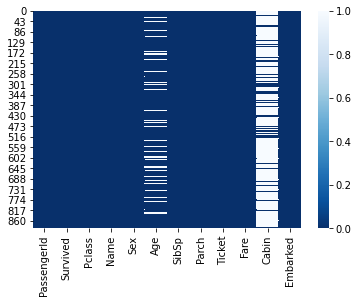

In [48]:
sns.heatmap(train.isna(), cmap='Blues_r')

<AxesSubplot:>

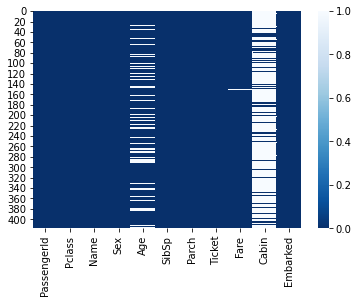

In [49]:
sns.heatmap(test.isna(), cmap='Blues_r')

In [50]:
total = train.isnull().sum().sort_values(ascending=False)
percent_1 = train.isnull().sum()/train.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
missing.head(5)

Total     %
Cabin       687  77.1
Age         177  19.9
Embarked      2   0.2
Fare          0   0.0
Ticket        0   0.0

## Data Preprocessing

### Filling missing Values

In [51]:
data = [train, test]
for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')

In [52]:
deck = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "U": 8}
data = [train, test]

for dataset in data:
    dataset['Cabin'] = dataset['Cabin'].fillna("U0")
    dataset['Deck'] = dataset['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
    dataset['Deck'] = dataset['Deck'].map(deck)
    dataset['Deck'] = dataset['Deck'].fillna(0)
    dataset['Deck'] = dataset['Deck'].astype(int)

train = train.drop(['Cabin'], axis=1)
test = test.drop(['Cabin'], axis=1)

In [53]:
data = [train, test]

for dataset in data:
    mean = dataset["Age"].mean()
    std = dataset["Age"].std()
    is_null = dataset["Age"].isnull().sum()
    rand_age = np.random.randint(mean - std, mean + std, size = is_null)
    dataset["Age"][np.isnan(dataset['Age'])] = rand_age
    dataset["Age"] = dataset["Age"].astype(int)

In [54]:
data = [train, test]
titles = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}

for dataset in data:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr',\
                                            'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    dataset['Title'] = dataset['Title'].map(titles)
    dataset['Title'] = dataset['Title'].fillna(0)

train = train.drop(['Name'], axis=1)
test = test.drop(['Name'], axis=1)

In [55]:
genders = {"male": 0, "female": 1}
data = [train, test]

for dataset in data:
    dataset['Sex'] = dataset['Sex'].map(genders)

In [56]:
ports = {"S": 0, "C": 1, "Q": 2}
data = [train, test]

for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].map(ports)

In [57]:
data = [train, test]

for dataset in data:
    dataset.loc[dataset['Fare'] < 8, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] >= 8) & (dataset['Fare'] < 12), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] >= 12) & (dataset['Fare'] < 30), 'Fare'] = 2
    dataset.loc[dataset['Fare'] >= 30, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].fillna(0)
    dataset['Fare'] = dataset['Fare'].astype(int)

for dataset in data:
    dataset.loc[dataset['Age'] < 15, 'Age'] = 0
    dataset.loc[(dataset['Age'] >= 15) & (dataset['Age'] < 25), 'Age'] = 1
    dataset.loc[(dataset['Age'] >= 25) & (dataset['Age'] < 65), 'Age'] = 2
    dataset.loc[dataset['Age'] >= 65, 'Age'] = 3


In [58]:
train = train.drop(['Ticket', 'PassengerId'], axis=1)
test = test.drop(['Ticket', 'PassengerId'], axis=1)

In [59]:
data = [train, test]
for dataset in data:
    dataset['Related'] = dataset['SibSp'] + dataset['Parch']
    dataset.loc[dataset['Related'] > 0, 'Not_Solo'] = 0
    dataset.loc[dataset['Related'] == 0, 'Not_Solo'] = 1
    dataset['Not_Solo'] = dataset['Not_Solo'].astype(int)

for dataset in data:
    dataset['Age_Class'] = dataset['Age'] * dataset['Pclass']

In [60]:
train.head()

Survived  Pclass  Sex  Age  SibSp  Parch  Fare  Embarked  Deck  Title  \
0         0       3    0    1      1      0     0         0     8      1   
1         1       1    1    2      1      0     3         1     3      3   
2         1       3    1    2      0      0     0         0     8      2   
3         1       1    1    2      1      0     3         0     3      3   
4         0       3    0    2      0      0     1         0     8      1   

   Related  Not_Solo  Age_Class  
0        1         0          3  
1        1         0          2  
2        0         1          6  
3        1         0          2  
4        0         1          6

In [61]:
test.head()

Pclass  Sex  Age  SibSp  Parch  Fare  Embarked  Deck  Title  Related  \
0       3    0    2      0      0     0         2     8      1        0   
1       3    1    2      1      0     0         0     8      3        1   
2       2    0    2      0      0     1         2     8      1        0   
3       3    0    2      0      0     1         0     8      1        0   
4       3    1    1      1      1     2         0     8      3        2   

   Not_Solo  Age_Class  
0         1          6  
1         0          6  
2         1          4  
3         1          6  
4         0          3

### Correlation Matrix

In [29]:
# plt.figure(figsize = (14,12))
# plt.title('Pearson Correlation of Features', y = 1.05, size = 15)
# sns.heatmap(X_tr.corr(), annot = True, cmap = 'RdBu', linecolor = 'white', square = True, linewidths = 0.2)

<img src='images/corrmap.png'>

### Pairplots

In [30]:
# g = sns.pairplot(data=train, hue='Survived', palette='icefire',
#                  size=1.2, diag_kind = 'kde', diag_kws=dict(shade=True), plot_kws=dict(s=10))
# g.set(xticklabels=[])
# plt.savefig('pairplot.png')

<img src='images/pairplot.png'>

##  Modeling

- Logistic Regression
- Random Forest
- Support Vector Machine
- K-Nearest Neighbor
- Gaussian Naive Bayes classifier
- Decision Tree
- Random Forest
- Ada Boost Classifier 
- Linear Discriminant Analysis
- Gradient Boosting Classifier

In [163]:
X = train.drop(columns=['Survived'], axis=1)
y = train['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [164]:
scaler = StandardScaler()
scaler.fit(X_train)
X_tr = scaler.transform(X_train)
X_tt = scaler.transform(X_test)

### Logistic Regression

#### Precision 
- measure of classifier's exactness, ratio pf true postiive to the sum of true and false positives
- "for all instanes classified positive, what percent was correct?"
#### Recall 
- measure of classifier's completeness, ability of classifier to correctly find all positive instanes, ratio of true positives to sum of true positives and false negatives
- "for all instances that were actaully positive, what percent was classified correctly?"
#### F1 Score
- weighted harmonic mean of precision and recall
- generally F1 score are lower than accuracy measures as they embed precision and recall
- weighted average of F1 should be used to compare classifier models, not global accuracy
#### Support
- number of actual occurrences of the class in specified dataset
- imbalanced support in training data may indicate structural weaknesses in reported scores of classifier and could indiccate need for stratified sampling or rebalancing
- support doesn't change between models but instead diagnoses the evaluation process

Training Accuracy:  0.8158682634730539
Testing Accuracy:  0.7937219730941704
Training F1 Score:  0.7494908350305498
Testing F1 Score:  0.7415730337078652
Training AUC Score: 0.8553073955902663
Testing AUC Score: 0.880345463692772
Training Recall Score:  0.7272727272727273
Testing Recall Score:  0.7415730337078652
Training Precision Score:  0.773109243697479
Testing Precision Score:  0.7415730337078652

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.84      0.87      0.85       415
           1       0.77      0.73      0.75       253

    accuracy                           0.82       668
   macro avg       0.81      0.80      0.80       668
weighted avg       0.81      0.82      0.81       668


Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.83      0.83      0.83       134
           1       0.74      0.74      0.74        89

    accuracy                         

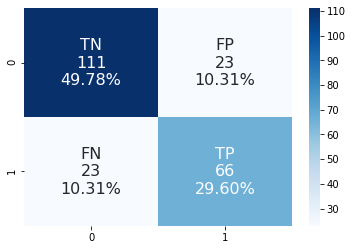

In [228]:
logreg = LogisticRegression(solver="liblinear", random_state=42).fit(X_tr, y_tr)
y_pred_log_tr = logreg.predict(X_tr)
y_pred_log_tt = logreg.predict(X_tt)
get_metrics(y_tr, y_tt, y_pred_log_tr, y_pred_log_tt, logreg)

### Random Forest Classifier

Training Accuracy:  0.9101796407185628
Testing Accuracy:  0.7892376681614349
Training F1 Score:  0.8765432098765432
Testing F1 Score:  0.7431693989071038
Training AUC Score: 0.9561121958188485
Testing AUC Score: 0.8569092738554419
Training Recall Score:  0.841897233201581
Testing Recall Score:  0.7640449438202247
Training Precision Score:  0.9141630901287554
Testing Precision Score:  0.723404255319149

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.91      0.95      0.93       415
           1       0.91      0.84      0.88       253

    accuracy                           0.91       668
   macro avg       0.91      0.90      0.90       668
weighted avg       0.91      0.91      0.91       668


Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.84      0.81      0.82       134
           1       0.72      0.76      0.74        89

    accuracy                         

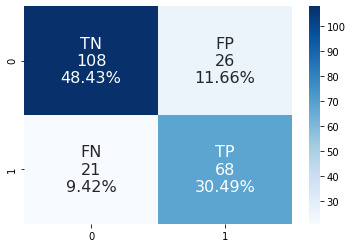

In [232]:
rfc = RandomForestClassifier().fit(X_tr, y_tr)
y_pred_rfc_tr = rfc.predict(X_tr)
y_pred_rfc_tt = rfc.predict(X_tt)
get_metrics(y_tr, y_tt, y_pred_rfc_tr, y_pred_rfc_tt, rfc)

### Support Vector Machines

Training Accuracy:  0.8502994011976048
Testing Accuracy:  0.820627802690583
Training F1 Score:  0.7899159663865548
Testing F1 Score:  0.7647058823529411
Training Recall Score:  0.7430830039525692
Testing Recall Score:  0.7303370786516854
Training Precision Score:  0.8430493273542601
Testing Precision Score:  0.8024691358024691

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.85      0.92      0.88       415
           1       0.84      0.74      0.79       253

    accuracy                           0.85       668
   macro avg       0.85      0.83      0.84       668
weighted avg       0.85      0.85      0.85       668


Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.83      0.88      0.86       134
           1       0.80      0.73      0.76        89

    accuracy                           0.82       223
   macro avg       0.82      0.81      0.81       223
weigh

<AxesSubplot:>

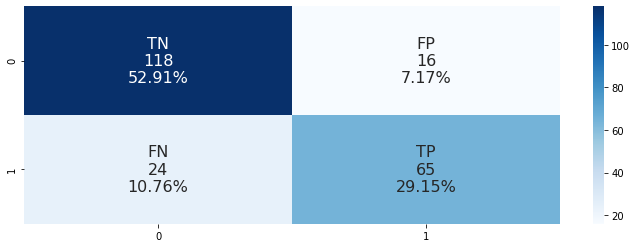

In [146]:
svc = SVC().fit(X_tr, y_tr)
y_pred_svc_tr = svc.predict(X_tr)
y_pred_svc_tt = svc.predict(X_tt)
cnf_matrix_svc = confusion_matrix(y_tt, y_pred_svc_tt)

print('Training Accuracy: ', accuracy(y_tr, y_pred_svc_tr))
print('Testing Accuracy: ', accuracy(y_tt, y_pred_svc_tt))
print('Training F1 Score: ', f1(y_tr, y_pred_svc_tr))
print('Testing F1 Score: ', f1(y_tt, y_pred_svc_tt))
#print('Training AUC Score: {}'.format(roc_auc_score(y_tr, svc.predict_proba(X_tr)[:,1])))
#print('Testing AUC Score: {}'.format(roc_auc_score(y_tt, svc.predict_proba(X_tt)[:,1])))
print('Training Recall Score: ', recall(y_tr, y_pred_svc_tr))
print('Testing Recall Score: ', recall(y_tt, y_pred_svc_tt))
print('Training Precision Score: ', precision(y_tr, y_pred_svc_tr))
print('Testing Precision Score: ', precision(y_tt, y_pred_svc_tt))
print('')
print("Training Classification Report: ")
print(classification_report(y_tr, y_pred_svc_tr))
print("")
print("Testing Classification Report: ")
print(classification_report(y_tt, y_pred_svc_tt))

group_names = ['TN','FP','FN','TP']
group_counts = ['{0:0.0f}'.format(value) for value in cnf_matrix_svc.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cnf_matrix_svc.flatten()/np.sum(cnf_matrix_svc)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cnf_matrix_svc, annot=labels, fmt='', cmap='Blues', annot_kws={'size':16})

### K-Nearest Neighbors

Training Accuracy:  0.8607784431137725
Testing Accuracy:  0.8116591928251121
Training F1 Score:  0.7910112359550562
Testing F1 Score:  0.7341772151898734
Training AUC Score: 0.9065431687223201
Testing AUC Score: 0.860976018782492
Training Recall Score:  0.6956521739130435
Testing Recall Score:  0.651685393258427
Training Precision Score:  0.9166666666666666
Testing Precision Score:  0.8405797101449275

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.84      0.96      0.90       415
           1       0.92      0.70      0.79       253

    accuracy                           0.86       668
   macro avg       0.88      0.83      0.84       668
weighted avg       0.87      0.86      0.86       668


Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.80      0.92      0.85       134
           1       0.84      0.65      0.73        89

    accuracy                         

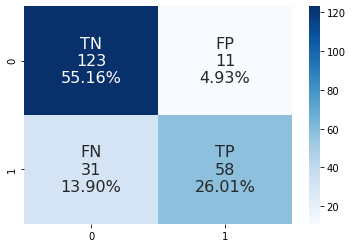

In [233]:
knn = KNeighborsClassifier(n_neighbors = 4).fit(X_tr, y_tr)
y_pred_knn_tr = knn.predict(X_tr)
y_pred_knn_tt = knn.predict(X_tt)
get_metrics(y_tr, y_tt, y_pred_knn_tr, y_pred_knn_tt, knn)

### Gaussian Naive Bayes

Training Accuracy:  0.7844311377245509
Testing Accuracy:  0.8026905829596412
Training F1 Score:  0.7323420074349443
Testing F1 Score:  0.7755102040816326
Training AUC Score: 0.8330777656078863
Testing AUC Score: 0.8632399798759014
Training Recall Score:  0.7786561264822134
Testing Recall Score:  0.8539325842696629
Training Precision Score:  0.6912280701754386
Testing Precision Score:  0.7102803738317757

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.85      0.79      0.82       415
           1       0.69      0.78      0.73       253

    accuracy                           0.78       668
   macro avg       0.77      0.78      0.78       668
weighted avg       0.79      0.78      0.79       668


Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.89      0.77      0.82       134
           1       0.71      0.85      0.78        89

    accuracy                       

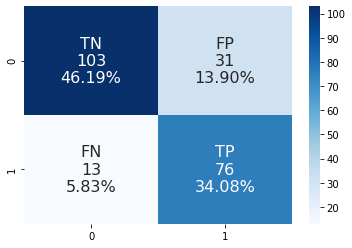

In [234]:
gnb = GaussianNB().fit(X_tr, y_tr)
y_pred_gnb_tr = gnb.predict(X_tr)
y_pred_gnb_tt = gnb.predict(X_tt)
get_metrics(y_tr, y_tt, y_pred_gnb_tr, y_pred_gnb_tt, gnb)

### Decision Tree

Training Accuracy:  0.9101796407185628
Testing Accuracy:  0.8161434977578476
Training F1 Score:  0.8712446351931331
Testing F1 Score:  0.7657142857142858
Training AUC Score: 0.9662364874517835
Testing AUC Score: 0.7887808150259936
Training Recall Score:  0.8023715415019763
Testing Recall Score:  0.7528089887640449
Training Precision Score:  0.9530516431924883
Testing Precision Score:  0.7790697674418605

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.89      0.98      0.93       415
           1       0.95      0.80      0.87       253

    accuracy                           0.91       668
   macro avg       0.92      0.89      0.90       668
weighted avg       0.91      0.91      0.91       668


Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.84      0.86      0.85       134
           1       0.78      0.75      0.77        89

    accuracy                       

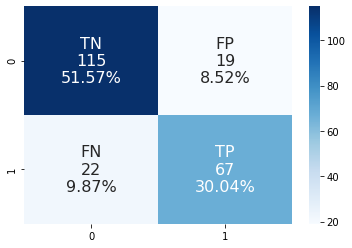

In [235]:
dtc = DecisionTreeClassifier().fit(X_tr, y_tr)
y_pred_dtc_tr = dtc.predict(X_tr)
y_pred_dtc_tt = dtc.predict(X_tt)
get_metrics(y_tr, y_tt, y_pred_dtc_tr, y_pred_dtc_tt, dtc)

### AdaBoost

Training Accuracy:  0.8383233532934131
Testing Accuracy:  0.8071748878923767
Training F1 Score:  0.782258064516129
Testing F1 Score:  0.7624309392265194
Training AUC Score: 0.893204438306586
Testing AUC Score: 0.8581251048130136
Training Recall Score:  0.766798418972332
Testing Recall Score:  0.7752808988764045
Training Precision Score:  0.7983539094650206
Testing Precision Score:  0.75

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.86      0.88      0.87       415
           1       0.80      0.77      0.78       253

    accuracy                           0.84       668
   macro avg       0.83      0.82      0.83       668
weighted avg       0.84      0.84      0.84       668


Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       134
           1       0.75      0.78      0.76        89

    accuracy                           0.81       22

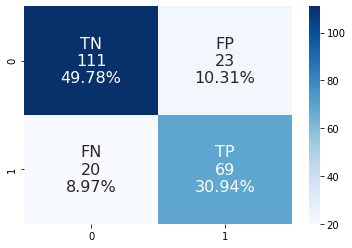

In [236]:
abc = AdaBoostClassifier().fit(X_tr, y_tr)
y_pred_abc_tr = abc.predict(X_tr)
y_pred_abc_tt = abc.predict(X_tt)
get_metrics(y_tr, y_tt, y_pred_abc_tr, y_pred_abc_tt, abc)

### Linear Discriminant Analysis

In [1]:
lda = LinearDiscriminantAnalysis().fit(X_tr, y_tr)
y_pred_lda_tr = abc.predict(X_tr)
y_pred_lda_tt = abc.predict(X_tt)
get_metrics(y_tr, y_tt, y_pred_lda_tr, y_pred_lda_tt, lda)

NameError: name 'LinearDiscriminantAnalysis' is not defined

### Gradient Boosting

Training Accuracy:  0.8772455089820359
Testing Accuracy:  0.8251121076233184
Training F1 Score:  0.8319672131147542
Testing F1 Score:  0.782122905027933
Training AUC Score: 0.9286775560740989
Testing AUC Score: 0.8598021130303539
Training Recall Score:  0.8023715415019763
Testing Recall Score:  0.7865168539325843
Training Precision Score:  0.8638297872340426
Testing Precision Score:  0.7777777777777778

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.88      0.92      0.90       415
           1       0.86      0.80      0.83       253

    accuracy                           0.88       668
   macro avg       0.87      0.86      0.87       668
weighted avg       0.88      0.88      0.88       668


Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.86      0.85      0.85       134
           1       0.78      0.79      0.78        89

    accuracy                        

<AxesSubplot:>

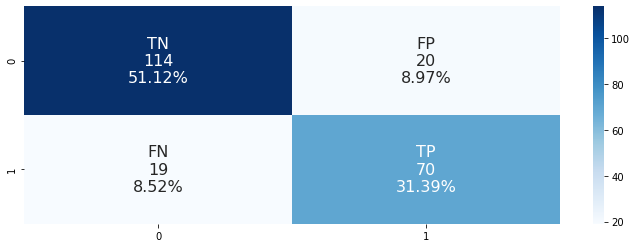

In [151]:
gbc = GradientBoostingClassifier().fit(X_tr, y_tr)
y_pred_gbc_tr = gbc.predict(X_tr)
y_pred_gbc_tt = gbc.predict(X_tt)
get_metrics(y_tr, y_tt, y_pred_gbc_tr, y_pred_gbc_tt, gbc)

# XGBoost Classifier

Training Accuracy:  0.9026946107784432
Testing Accuracy:  0.8340807174887892
Training F1 Score:  0.8648648648648649
Testing F1 Score:  0.7978142076502731
Training AUC Score: 0.9539835230249059
Testing AUC Score: 0.8727150763038738
Training Recall Score:  0.8221343873517787
Testing Recall Score:  0.8202247191011236
Training Precision Score:  0.9122807017543859
Testing Precision Score:  0.776595744680851

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.90      0.95      0.92       415
           1       0.91      0.82      0.86       253

    accuracy                           0.90       668
   macro avg       0.91      0.89      0.89       668
weighted avg       0.90      0.90      0.90       668


Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       134
           1       0.78      0.82      0.80        89

    accuracy                        

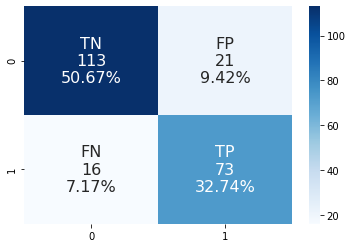

In [237]:
xgb = XGBClassifier(verbosity = 0).fit(X_tr, y_tr)
y_pred_xgb_tr = xgb.predict(X_tr)
y_pred_xgb_tt = xgb.predict(X_tt)
get_metrics(y_tr, y_tt, y_pred_xgb_tr, y_pred_xgb_tt, xgb)

## Model evaluation
We can now rank our evaluation of all the models to choose the best one for our problem.

In [238]:
data = {'Accuracy': [accuracy(y_tt, y_pred_log_tt), 
                     accuracy(y_tt, y_pred_rfc_tt), 
                     accuracy(y_tt, y_pred_knn_tt), 
                     accuracy(y_tt, y_pred_gnb_tt), 
                     accuracy(y_tt, y_pred_dtc_tt), 
                     accuracy(y_tt, y_pred_abc_tt), 
                     accuracy(y_tt, y_pred_lda_tt), 
                     accuracy(y_tt, y_pred_gbc_tt),
                     accuracy(y_tt, y_pred_svc_tt),
                     accuracy(y_tt, y_pred_xgb_tt)],
        'F1 Score': [f1(y_tt, y_pred_log_tt), 
                     f1(y_tt, y_pred_rfc_tt), 
                     f1(y_tt, y_pred_knn_tt), 
                     f1(y_tt, y_pred_gnb_tt), 
                     f1(y_tt, y_pred_dtc_tt), 
                     f1(y_tt, y_pred_abc_tt), 
                     f1(y_tt, y_pred_lda_tt), 
                     f1(y_tt, y_pred_gbc_tt),
                     f1(y_tt, y_pred_svc_tt),
                     f1(y_tt, y_pred_xgb_tt)],
        'AUC Score': [roc_auc_score(y_tt, logreg.predict_proba(X_tt)[:,1]),
                      roc_auc_score(y_tt, rfc.predict_proba(X_tt)[:,1]),
                      roc_auc_score(y_tt, knn.predict_proba(X_tt)[:,1]),
                      roc_auc_score(y_tt, gnb.predict_proba(X_tt)[:,1]),
                      roc_auc_score(y_tt, dtc.predict_proba(X_tt)[:,1]),
                      roc_auc_score(y_tt, abc.predict_proba(X_tt)[:,1]),
                      roc_auc_score(y_tt, lda.predict_proba(X_tt)[:,1]),
                      roc_auc_score(y_tt, gbc.predict_proba(X_tt)[:,1]),
                      np.nan,
                      roc_auc_score(y_tt, xgb.predict_proba(X_tt)[:,1])],
        'Recall': [recall(y_tt, y_pred_log_tt), 
                   recall(y_tt, y_pred_rfc_tt), 
                   recall(y_tt, y_pred_knn_tt), 
                   recall(y_tt, y_pred_gnb_tt), 
                   recall(y_tt, y_pred_dtc_tt), 
                   recall(y_tt, y_pred_abc_tt), 
                   recall(y_tt, y_pred_lda_tt), 
                   recall(y_tt, y_pred_gbc_tt),
                   recall(y_tt, y_pred_svc_tt),
                   recall(y_tt, y_pred_xgb_tt)],
        'Precision': [precision(y_tt, y_pred_log_tt), 
                      precision(y_tt, y_pred_rfc_tt), 
                      precision(y_tt, y_pred_knn_tt), 
                      precision(y_tt, y_pred_gnb_tt), 
                      precision(y_tt, y_pred_dtc_tt), 
                      precision(y_tt, y_pred_abc_tt), 
                      precision(y_tt, y_pred_lda_tt), 
                      precision(y_tt, y_pred_gbc_tt),
                      precision(y_tt, y_pred_svc_tt),
                      precision(y_tt, y_pred_xgb_tt)]}
scores = pd.DataFrame(data=data, index = ['Logistic Regression', 
                                          'Random Forest Classifier', 
                                          'K-Nearest Neighbors', 
                                          'Gaussian Naive Bayes', 
                                          'Decision Tree Classifier', 
                                          'AdaBoost Classifier', 
                                          'Linear Discriminant Analysis', 
                                          'Gradient Boosting Classifier',
                                          'Support Vector Machine',
                                          'XGBoost Classifier'])
scores

Accuracy  F1 Score  AUC Score    Recall  \
Logistic Regression           0.793722  0.741573   0.880345  0.741573   
Random Forest Classifier      0.789238  0.743169   0.856909  0.764045   
K-Nearest Neighbors           0.811659  0.734177   0.860976  0.651685   
Gaussian Naive Bayes          0.802691  0.775510   0.863240  0.853933   
Decision Tree Classifier      0.816143  0.765714   0.788781  0.752809   
AdaBoost Classifier           0.807175  0.762431   0.858125  0.775281   
Linear Discriminant Analysis  0.807175  0.762431   0.878501  0.775281   
Gradient Boosting Classifier  0.825112  0.782123   0.859802  0.786517   
Support Vector Machine        0.820628  0.764706        NaN  0.730337   
XGBoost Classifier            0.834081  0.797814   0.872715  0.820225   

                              Precision  
Logistic Regression            0.741573  
Random Forest Classifier       0.723404  
K-Nearest Neighbors            0.840580  
Gaussian Naive Bayes           0.710280  
Decision Tree Classifier       0.779070  
AdaBoost Classifier            0.750000  
Linear Discriminant Analysis   0.750000  
Gradient Boosting Classifier   0.777778  
Support Vector Machine         0.802469  
XGBoost Classifier             0.776596

## Decision Tree, Bagging Classifier, Random Forest

Training Accuracy:  0.8547904191616766
Testing Accuracy:  0.8251121076233184
Training F1 Score:  0.781038374717833
Testing F1 Score:  0.7664670658682635
Training AUC Score: 0.9082813467307969
Testing AUC Score: 0.8679775280898876
Training Recall Score:  0.6837944664031621
Testing Recall Score:  0.7191011235955056
Training Precision Score:  0.9105263157894737
Testing Precision Score:  0.8205128205128205

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.83      0.96      0.89       415
           1       0.91      0.68      0.78       253

    accuracy                           0.85       668
   macro avg       0.87      0.82      0.84       668
weighted avg       0.86      0.85      0.85       668


Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.83      0.90      0.86       134
           1       0.82      0.72      0.77        89

    accuracy                        

<AxesSubplot:>

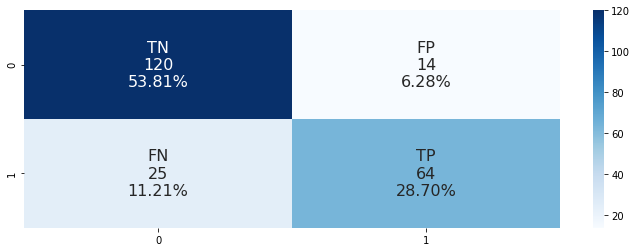

In [158]:
dtc2 = DecisionTreeClassifier(criterion='gini', max_depth=5)
dtc2.fit(X_tr, y_tr)
y_pred_dtc2_tr = dtc2.predict(X_tr)
y_pred_dtc2_tt = dtc2.predict(X_tt)
get_metrics(y_tr, y_tt, y_pred_dtc2_tr, y_pred_dtc2_tt, dtc2)

In [159]:
dtc2.feature_importances_

array([0.17399471, 0.        , 0.00340572, 0.        , 0.00521481,
       0.01692568, 0.02425964, 0.06458225, 0.61154252, 0.08020797,
       0.        , 0.01986671])

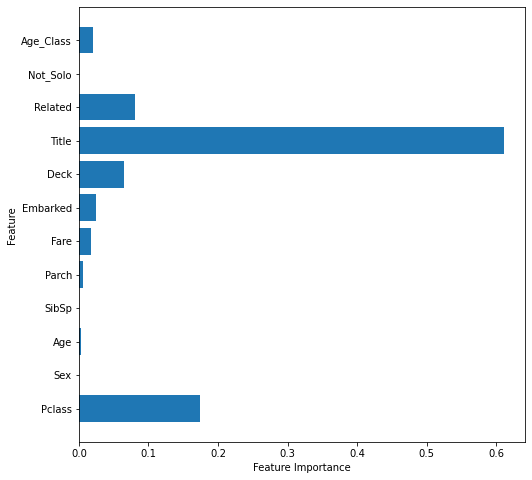

In [166]:
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(8, 8))
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), X_train.columns.values)
    plt.xlabel("Feature Importance")
    plt.ylabel('Feature')

plot_feature_importances(dtc2)
plt.savefig('images/dtc2_feature_importance.png')

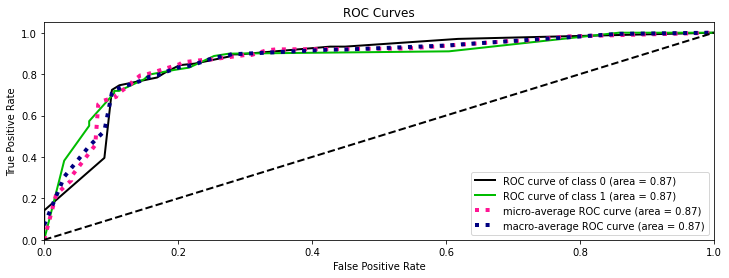

In [172]:
import scikitplot as skplt #to make things easy
y_pred_proba = dtc2.predict_proba(X_tt)
skplt.metrics.plot_roc_curve(y_tt, y_pred_proba)
plt.show()


Training Accuracy:  0.8697604790419161
Testing Accuracy:  0.820627802690583
Training F1 Score:  0.8220858895705521
Testing F1 Score:  0.7777777777777778
Training AUC Score: 0.9203819229487118
Testing AUC Score: 0.8855022639610933
Training Recall Score:  0.7944664031620553
Testing Recall Score:  0.7865168539325843
Training Precision Score:  0.8516949152542372
Testing Precision Score:  0.7692307692307693

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.88      0.92      0.90       415
           1       0.85      0.79      0.82       253

    accuracy                           0.87       668
   macro avg       0.87      0.86      0.86       668
weighted avg       0.87      0.87      0.87       668


Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.86      0.84      0.85       134
           1       0.77      0.79      0.78        89

    accuracy                        

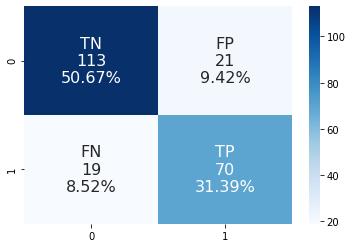

In [239]:
bc = BaggingClassifier(DecisionTreeClassifier(criterion='gini', max_depth=5), n_estimators=20).fit(X_tr, y_tr)
y_pred_bc_tr = bc.predict(X_tr)
y_pred_bc_tt = bc.predict(X_tt)
get_metrics(y_tr, y_tt, y_pred_bc_tr, y_pred_bc_tt, bc)

Training Accuracy:  0.8607784431137725
Testing Accuracy:  0.8251121076233184
Training F1 Score:  0.8042105263157895
Testing F1 Score:  0.7719298245614036
Training AUC Score: 0.9062336301728653
Testing AUC Score: 0.886382693275197
Training Recall Score:  0.7549407114624506
Testing Recall Score:  0.7415730337078652
Training Precision Score:  0.8603603603603603
Testing Precision Score:  0.8048780487804879

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.86      0.93      0.89       415
           1       0.86      0.75      0.80       253

    accuracy                           0.86       668
   macro avg       0.86      0.84      0.85       668
weighted avg       0.86      0.86      0.86       668


Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.84      0.88      0.86       134
           1       0.80      0.74      0.77        89

    accuracy                        

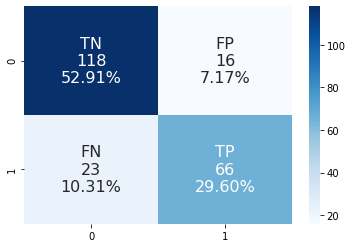

In [240]:
rfc2 = RandomForestClassifier(n_estimators=100, max_depth=5).fit(X_tr, y_tr)
y_pred_rfc2_tr = rfc2.predict(X_tr)
y_pred_rfc2_tt = rfc2.predict(X_tt)
get_metrics(y_tr, y_tt, y_pred_rfc2_tr, y_pred_rfc2_tt, rfc2)

In [176]:
rfc2.feature_importances_

array([0.07903485, 0.2009544 , 0.02423918, 0.03698242, 0.02160602,
       0.05293811, 0.01762511, 0.07681087, 0.34756812, 0.0590956 ,
       0.00952724, 0.07361807])

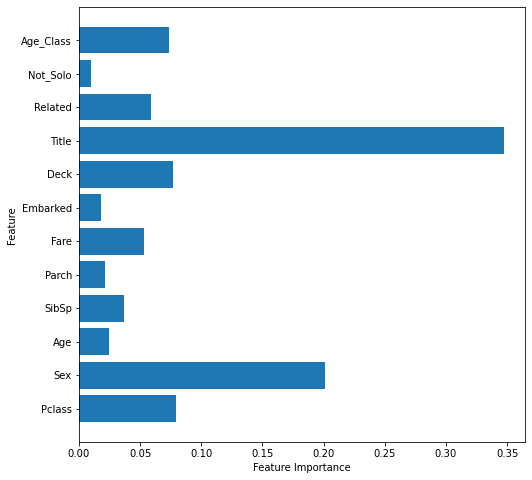

In [177]:
plot_feature_importances(rfc2)
plt.savefig('images/rf_feature_importance.png')

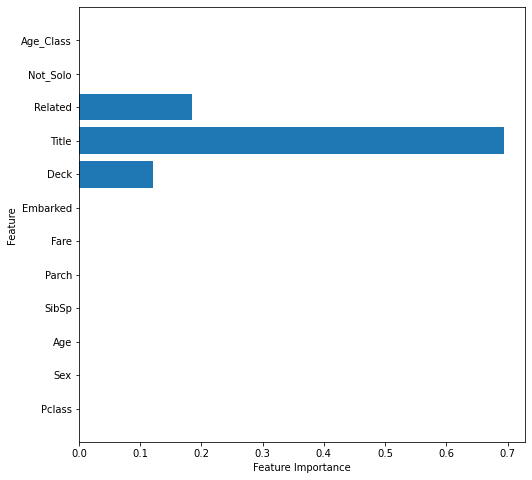

In [178]:
rfc3 = RandomForestClassifier(n_estimators=5, max_features=10, max_depth=2).fit(X_tr, y_tr)
rf_tree_1 = rfc3.estimators_[0]
plot_feature_importances(rf_tree_1)

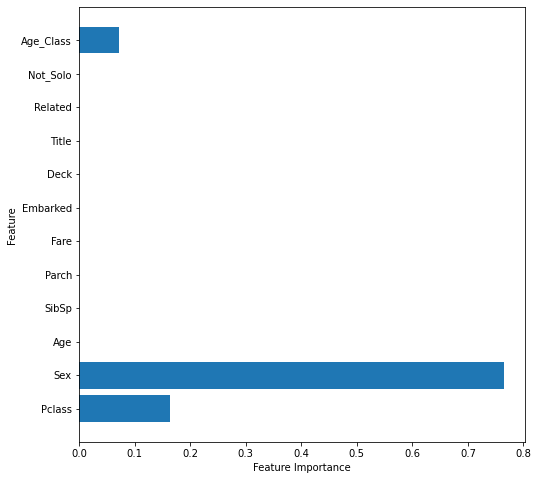

In [179]:
rf_tree_2 = rfc3.estimators_[1]
plot_feature_importances(rf_tree_2)

## Voting Classifier with Random Forest, SVC, and Logistic Regression

In [115]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(solver="liblinear", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=10, random_state=42)
svm_clf = SVC(gamma="auto", random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')

In [116]:
voting_clf.fit(X_tr, y_tr)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(random_state=42,
                                                 solver='liblinear')),
                             ('rf',
                              RandomForestClassifier(n_estimators=10,
                                                     random_state=42)),
                             ('svc', SVC(gamma='auto', random_state=42))])

In [118]:
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_tr, y_tr)
    y_pred = clf.predict(X_tt)
    print(clf.__class__.__name__, accuracy_score(y_tt, y_pred))

LogisticRegression 0.7937219730941704
RandomForestClassifier 0.8116591928251121
SVC 0.820627802690583
VotingClassifier 0.820627802690583


In [242]:
log_clf = LogisticRegression(solver="liblinear", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=10, random_state=42)
svm_clf = SVC(gamma="auto", probability=True, random_state=42)

vc = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
vc.fit(X_tr, y_tr)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(random_state=42,
                                                 solver='liblinear')),
                             ('rf',
                              RandomForestClassifier(n_estimators=10,
                                                     random_state=42)),
                             ('svc',
                              SVC(gamma='auto', probability=True,
                                  random_state=42))],
                 voting='soft')

In [243]:
for clf in (log_clf, rnd_clf, svm_clf, vc):
    clf.fit(X_tr, y_tr)
    y_pred = clf.predict(X_tt)
    print(clf.__class__.__name__, accuracy_score(y_tt, y_pred))

LogisticRegression 0.7937219730941704
RandomForestClassifier 0.8116591928251121
SVC 0.820627802690583
VotingClassifier 0.8251121076233184


Training Accuracy:  0.8682634730538922
Testing Accuracy:  0.8251121076233184
Training F1 Score:  0.8135593220338982
Testing F1 Score:  0.7692307692307693
Training AUC Score: 0.9258440878137053
Testing AUC Score: 0.8825255743753145
Training Recall Score:  0.758893280632411
Testing Recall Score:  0.7303370786516854
Training Precision Score:  0.8767123287671232
Testing Precision Score:  0.8125

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.86      0.93      0.90       415
           1       0.88      0.76      0.81       253

    accuracy                           0.87       668
   macro avg       0.87      0.85      0.86       668
weighted avg       0.87      0.87      0.87       668


Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.83      0.89      0.86       134
           1       0.81      0.73      0.77        89

    accuracy                           0.83     

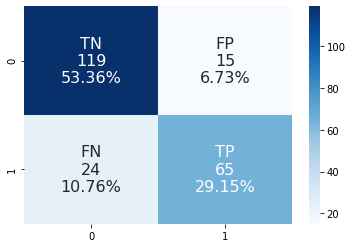

In [244]:
y_pred_vc_tr = vc.predict(X_tr)
y_pred_vc_tt = vc.predict(X_tt)
get_metrics(y_tr, y_tt, y_pred_vc_tr, y_pred_vc_tt, vc)

## Hyperparameters Tuning

**Parameters**

- n_jobs : Number of cores used for the training process. If set to -1, all cores are used.
- n_estimators : Number of classification trees in your learning model ( set to 10 per default)
- max_depth : Maximum depth of tree, or how much a node should be expanded. Beware if set to too high a number would run the risk of overfitting as one would be growing the tree too deep
- verbose : Controls whether you want to output any text during the learning process. A value of 0 suppresses all text while a value of 3 outputs the tree learning process at every iteration.


## XGBoost Classifier with GridSearchCV

Grid Search found the following optimal parameters: 
learning_rate: 0.01
max_depth: 5
min_child_weight: 1
n_estimators: 100
subsample: 0.9
Training Accuracy:  0.8592814371257484
Testing Accuracy:  0.8295964125560538
Training F1 Score:  0.8008474576271186
Testing F1 Score:  0.7840909090909092
Training AUC Score: 0.9102052478689461
Testing AUC Score: 0.8758175415059535
Training Recall Score:  0.7470355731225297
Testing Recall Score:  0.7752808988764045
Training Precision Score:  0.863013698630137
Testing Precision Score:  0.7931034482758621

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.86      0.93      0.89       415
           1       0.86      0.75      0.80       253

    accuracy                           0.86       668
   macro avg       0.86      0.84      0.85       668
weighted avg       0.86      0.86      0.86       668


Testing Classification Report: 
              precision    recall  f1-score   support

      

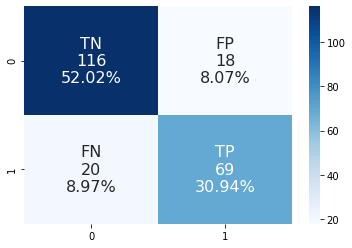

In [246]:
xgb2 = XGBClassifier(verbosity = 0).fit(X_tr, y_tr)
y_pred_xgb2_tr = xgb2.predict(X_tr)
y_pred_xgb2_tt = xgb2.predict(X_tt)
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [5, 6, 8],
    'min_child_weight': [1, 2, 3],
    'subsample': [0.7, 0.9, 1.1],
    'n_estimators': [100, 200, 300],
}
grid_xgb2 = GridSearchCV(xgb2, param_grid, scoring='accuracy', cv=None, n_jobs=1).fit(X_tr, y_tr)
best_param_xgb = grid_xgb2.best_params_
print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_param_xgb.keys()):
    print('%s: %r' % (param_name, best_param_xgb[param_name]))
y_pred_xgbgs2_tr = grid_xgb2.predict(X_tr)
y_pred_xgbgs2_tt = grid_xgb2.predict(X_tt)
print("")
get_metrics(y_tr, y_tt, y_pred_xgbgs2_tr, y_pred_xgbgs2_tt, grid_xgb2)

# Grid Search found the following optimal parameters: 
# learning_rate: 0.01
# max_depth: 5
# min_child_weight: 1
# n_estimators: 100
# subsample: 0.9

### GBC Feature Importance


Model Report
Accuracy : 0.8653
AUC Score (Train): 0.918781
CV Score : Mean - 0.8711452 | Std - 0.04021398 | Min - 0.8110294 | Max - 0.9251429


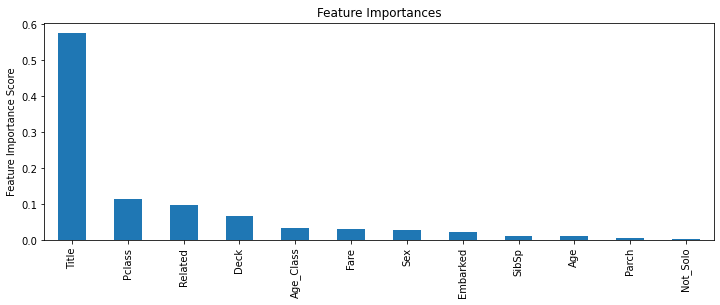

In [95]:
predictors = [x for x in train.columns if x not in [target]]
gbm0 = GradientBoostingClassifier(random_state=42)
modelfit(gbm0, train, predictors)

### Gradient Boosting with GridSearchCV

In [33]:
gbc2 = GradientBoostingClassifier()
param_grid = {'n_estimators' : [10, 50, 100, 200, 400],
              'learning_rate': [0.25, 0.1, 0.05, 0.01, 0.001],
              'max_depth': [2, 4, 6, 8],
              'max_features': ['auto', 'log2', 'sqrt'],
              'min_samples_split': [0.05, 0.1, 0.25, 0.5],
              'min_samples_leaf': [0.05, 0.1, 0.25, 0.5] 
              }
gbm = GridSearchCV(gbc2, param_grid=param_grid, cv=5, scoring="accuracy", verbose=1)
gbm.fit(X_train, y_train)
print(f"Training Accuracy: {gbm.best_score_ :.2%}")
gbm.best_estimator_

# Fitting 5 folds for each of 4800 candidates, totalling 24000 fits
# Training Accuracy: 83.50%
# GradientBoostingClassifier(learning_rate=0.25, max_depth=4, max_features='auto',
#                            min_samples_leaf=0.05, min_samples_split=0.25,
#                            n_estimators=50)

Fitting 5 folds for each of 4800 candidates, totalling 24000 fits
Training Accuracy: 83.50%


GradientBoostingClassifier(learning_rate=0.25, max_depth=4, max_features='auto',
                           min_samples_leaf=0.05, min_samples_split=0.25,
                           n_estimators=50)

Training Accuracy:  0.8592814371257484
Testing Accuracy:  0.8116591928251121
Training F1 Score:  0.8065843621399176
Testing F1 Score:  0.7613636363636362
Training AUC Score: 0.9084099242821086
Testing AUC Score: 0.877033372463525
Training Recall Score:  0.7747035573122529
Testing Recall Score:  0.7528089887640449
Training Precision Score:  0.8412017167381974
Testing Precision Score:  0.7701149425287356

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.87      0.91      0.89       415
           1       0.84      0.77      0.81       253

    accuracy                           0.86       668
   macro avg       0.86      0.84      0.85       668
weighted avg       0.86      0.86      0.86       668


Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.84      0.85      0.84       134
           1       0.77      0.75      0.76        89

    accuracy                        

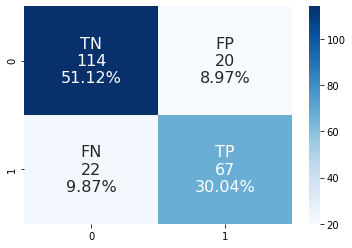

In [247]:
gbc_best = GradientBoostingClassifier(learning_rate=0.25,
                                   max_depth=4,
                                   max_features='auto',
                                   min_samples_leaf=0.05,
                                   min_samples_split=0.25,
                                   n_estimators=50).fit(X_tr, y_tr)
y_pred_gbc_best_tr = gbc_best.predict(X_tr)
y_pred_gbc_best_tt = gbc_best.predict(X_tt)
get_metrics(y_tr, y_tt, y_pred_gbc_best_tr, y_pred_gbc_best_tt, gbc_best)

In [ ]:
4152370403

### Decision Tree and Random Forest with GridSearchCV

In [71]:
dtc3 = DecisionTreeClassifier()
dtc_cv_score = cross_val_score(dtc3, X_train, y_train, cv=3)
mean_dtc_cv_score = np.mean(dtc_cv_score)
print(f"Mean Cross Validation Score: {mean_dtc_cv_score :.2%}")

Mean Cross Validation Score: 81.37%


In [75]:
dt_param_grid = {'criterion': ['gini', 'entropy'],
              'max_depth': [None, 2, 4, 6, 8, 12],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 3, 4, 5, 6]
              }
dtc_grid_search = GridSearchCV(dtc3, dt_param_grid, cv=3, return_train_score=True, scoring="accuracy")
dtc_grid_search.fit(X_train, y_train)
dtc_gs_score = np.mean(dtc_grid_search.cv_results_['mean_train_score'])
print(f"Mean Training Score: {dtc_gs_score :.2%}")
print(f"Training Accuracy: {model.best_score_ :.2%}")
print("Best Parameter Combination:") 
dtc_grid_search.best_params_

# Mean Training Score: 84.99%
# Best Parameter Combination:
# {'criterion': 'gini',
#  'max_depth': 4,
#  'min_samples_leaf': 2,
#  'min_samples_split': 2}

Mean Training Score: 84.99%
Best Parameter Combination:


{'criterion': 'gini',
 'max_depth': 4,
 'min_samples_leaf': 2,
 'min_samples_split': 2}

Training Accuracy:  0.844311377245509
Testing Accuracy:  0.8161434977578476
Training F1 Score:  0.7886178861788619
Testing F1 Score:  0.7709497206703911
Training AUC Score: 0.8943092528215629
Testing AUC Score: 0.8666359215160154
Training Recall Score:  0.766798418972332
Testing Recall Score:  0.7752808988764045
Training Precision Score:  0.8117154811715481
Testing Precision Score:  0.7666666666666667

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.86      0.89      0.88       415
           1       0.81      0.77      0.79       253

    accuracy                           0.84       668
   macro avg       0.84      0.83      0.83       668
weighted avg       0.84      0.84      0.84       668


Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.85      0.84      0.85       134
           1       0.77      0.78      0.77        89

    accuracy                         

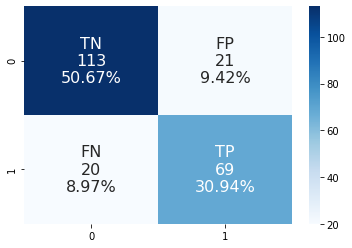

In [250]:
dtc_best = DecisionTreeClassifier(criterion='gini',
                                  max_depth=4,
                                  min_samples_leaf=2,
                                  min_samples_split=2).fit(X_tr, y_tr)
y_pred_dtc_best_tr = dtc_best.predict(X_tr)
y_pred_dtc_best_tt = dtc_best.predict(X_tt)
get_metrics(y_tr, y_tt, y_pred_dtc_best_tr, y_pred_dtc_best_tt, dtc_best)

In [76]:
rf_2 = RandomForestClassifier()
rf_2_cv_score = np.mean(cross_val_score(rf_2, X_train, y_train, cv=3))
print(f"Mean Cross Validation Score: {rf_2_cv_score :.2%}")
param_grid = {'criterion': ['gini', 'entropy'],
              'n_estimators': [10, 50, 100, 250, 500],
              'max_depth': [None, 2, 6, 12],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [3, 6]
              }
rf_gs = GridSearchCV(rf_2, param_grid, cv=3, scoring="accuracy", verbose=1)
rf_gs.fit(X_train, y_train)
print(f"Training Accuracy: {rf_gs.best_score_ :.2%}")
rf_gs.best_estimator_

# Mean Cross Validation Score: 82.15%
# Fitting 3 folds for each of 240 candidates, totalling 720 fits
# Training Accuracy: 83.39%
# RandomForestClassifier(criterion='entropy', max_depth=12, min_samples_leaf=3,
#                        n_estimators=50)

Mean Cross Validation Score: 82.15%
Fitting 3 folds for each of 240 candidates, totalling 720 fits
Training Accuracy: 83.39%


RandomForestClassifier(criterion='entropy', max_depth=12, min_samples_leaf=3,
                       n_estimators=50)

Training Accuracy:  0.8727544910179641
Testing Accuracy:  0.8340807174887892
Training F1 Score:  0.8225469728601252
Testing F1 Score:  0.783625730994152
Training AUC Score: 0.9210057621791514
Testing AUC Score: 0.8843702834143887
Training Recall Score:  0.7786561264822134
Testing Recall Score:  0.7528089887640449
Training Precision Score:  0.8716814159292036
Testing Precision Score:  0.8170731707317073

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.87      0.93      0.90       415
           1       0.87      0.78      0.82       253

    accuracy                           0.87       668
   macro avg       0.87      0.85      0.86       668
weighted avg       0.87      0.87      0.87       668


Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.84      0.89      0.87       134
           1       0.82      0.75      0.78        89

    accuracy                        

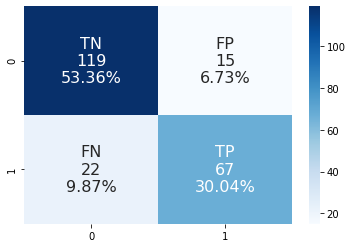

In [248]:
rfc_best = RandomForestClassifier(criterion='entropy', 
                                  max_depth=12, 
                                  min_samples_leaf=3,
                                  n_estimators=50).fit(X_tr, y_tr)
y_pred_rfc_best_tr = rfc_best.predict(X_tr)
y_pred_rfc_best_tt = rfc_best.predict(X_tt)
get_metrics(y_tr, y_tt, y_pred_rfc_best_tr, y_pred_rfc_best_tt, rfc_best)

### Linear Discriminant Analysis with GridSearchCV

In [35]:
clf = LinearDiscriminantAnalysis()
param_grid = {'tol': [0.001, 0.01, 0.1, 0.2]}
model = GridSearchCV(clf, param_grid=param_grid, cv=5, scoring="accuracy", n_jobs= 4, verbose=1)
model.fit(X_train, y_train)
print(f"Training Accuracy: {model.best_score_ :.2%}")
model.best_estimator_

# Fitting 5 folds for each of 4 candidates, totalling 20 fits
# Training Accuracy: 80.25%
# LinearDiscriminantAnalysis(tol=0.001)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Training Accuracy: 80.25%


LinearDiscriminantAnalysis(tol=0.001)

Training Accuracy:  0.8083832335329342
Testing Accuracy:  0.7847533632286996
Training F1 Score:  0.7398373983739838
Testing F1 Score:  0.7303370786516854
Training AUC Score: 0.8562979189485213
Testing AUC Score: 0.8785007546536978
Training Recall Score:  0.7193675889328063
Testing Recall Score:  0.7303370786516854
Training Precision Score:  0.7615062761506276
Testing Precision Score:  0.7303370786516854

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.83      0.86      0.85       415
           1       0.76      0.72      0.74       253

    accuracy                           0.81       668
   macro avg       0.80      0.79      0.79       668
weighted avg       0.81      0.81      0.81       668


Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.82      0.82      0.82       134
           1       0.73      0.73      0.73        89

    accuracy                       

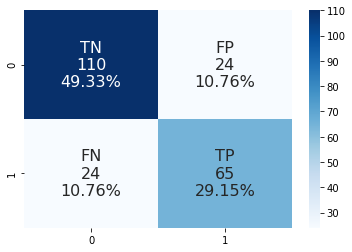

In [254]:
lda_best = LinearDiscriminantAnalysis(tol=0.001).fit(X_tr, y_tr)
y_pred_lda_best_tr = lda_best.predict(X_tr)
y_pred_lda_best_tt = lda_best.predict(X_tt)
get_metrics(y_tr, y_tt, y_pred_lda_best_tr, y_pred_lda_best_tt, lda_best)

### Support Vector Machines with GridSearchCV

In [36]:
clf = SVC()
param_grid = {'kernel': ['rbf', 'linear'], 
              'gamma': [ 0.001, 0.01, 0.1, 1],
              'C': [1, 10, 50, 100, 200, 300, 1000]}
model = GridSearchCV(clf, param_grid, cv=5, scoring="accuracy", n_jobs=4, verbose=1)
model.fit(X_train, y_train)
print(f"Training Accuracy: {model.best_score_ :.2%}")
model.best_estimator_

# Fitting 5 folds for each of 56 candidates, totalling 280 fits
# Training Accuracy: 82.60%
# SVC(C=50, gamma=0.01)

Fitting 5 folds for each of 56 candidates, totalling 280 fits
Training Accuracy: 82.60%


SVC(C=50, gamma=0.01)

Training Accuracy:  0.842814371257485
Testing Accuracy:  0.820627802690583
Training F1 Score:  0.7807933194154488
Testing F1 Score:  0.7674418604651162
Training Recall Score:  0.7391304347826086
Testing Recall Score:  0.7415730337078652
Training Precision Score:  0.827433628318584
Testing Precision Score:  0.7951807228915663

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.85      0.91      0.88       415
           1       0.83      0.74      0.78       253

    accuracy                           0.84       668
   macro avg       0.84      0.82      0.83       668
weighted avg       0.84      0.84      0.84       668


Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.84      0.87      0.85       134
           1       0.80      0.74      0.77        89

    accuracy                           0.82       223
   macro avg       0.82      0.81      0.81       223
weighte

<AxesSubplot:>

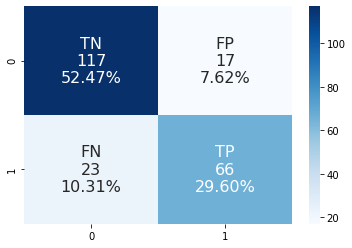

In [260]:
svc_best = SVC(C=50, gamma=0.01).fit(X_tr, y_tr)
y_pred_svc_best_tr = svc_best.predict(X_tr)
y_pred_svc_best_tt = svc_best.predict(X_tt)
cnf_matrix_svc_best = confusion_matrix(y_tt, y_pred_svc_best_tt)

print('Training Accuracy: ', accuracy(y_tr, y_pred_svc_best_tr))
print('Testing Accuracy: ', accuracy(y_tt, y_pred_svc_best_tt))
print('Training F1 Score: ', f1(y_tr, y_pred_svc_best_tr))
print('Testing F1 Score: ', f1(y_tt, y_pred_svc_best_tt))
#print('Training AUC Score: {}'.format(roc_auc_score(y_tr, svc.predict_proba(X_tr)[:,1])))
#print('Testing AUC Score: {}'.format(roc_auc_score(y_tt, svc.predict_proba(X_tt)[:,1])))
print('Training Recall Score: ', recall(y_tr, y_pred_svc_best_tr))
print('Testing Recall Score: ', recall(y_tt, y_pred_svc_best_tt))
print('Training Precision Score: ', precision(y_tr, y_pred_svc_best_tr))
print('Testing Precision Score: ', precision(y_tt, y_pred_svc_best_tt))
print('')
print("Training Classification Report: ")
print(classification_report(y_tr, y_pred_svc_best_tr))
print("")
print("Testing Classification Report: ")
print(classification_report(y_tt, y_pred_svc_best_tt))

group_names = ['TN','FP','FN','TP']
group_counts = ['{0:0.0f}'.format(value) for value in cnf_matrix_svc_best.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cnf_matrix_svc_best.flatten()/np.sum(cnf_matrix_svc_best)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cnf_matrix_svc_best, annot=labels, fmt='', cmap='Blues', annot_kws={'size':16})

In [261]:
data_2 = {'Accuracy': [accuracy(y_tt, y_pred_dtc2_tt), 
                       accuracy(y_tt, y_pred_rfc2_tt), 
                       accuracy(y_tt, y_pred_vc_tt), 
                       accuracy(y_tt, y_pred_bc_tt), 
                       accuracy(y_tt, y_pred_xgb2_tt), 
                       accuracy(y_tt, y_pred_gbc_best_tt), 
                       accuracy(y_tt, y_pred_rfc_best_tt), 
                       accuracy(y_tt, y_pred_dtc_best_tt),
                       accuracy(y_tt, y_pred_lda_best_tt),
                       accuracy(y_tt, y_pred_svc_best_tt)],
          'F1 Score': [f1(y_tt, y_pred_dtc2_tt), 
                       f1(y_tt, y_pred_rfc2_tt), 
                       f1(y_tt, y_pred_vc_tt), 
                       f1(y_tt, y_pred_bc_tt), 
                       f1(y_tt, y_pred_xgb2_tt), 
                       f1(y_tt, y_pred_gbc_best_tt), 
                       f1(y_tt, y_pred_rfc_best_tt), 
                       f1(y_tt, y_pred_dtc_best_tt),
                       f1(y_tt, y_pred_lda_best_tt),
                       f1(y_tt, y_pred_svc_best_tt)],
          'AUC Score': [roc_auc_score(y_tt, dtc2.predict_proba(X_tt)[:,1]),
                        roc_auc_score(y_tt, rfc2.predict_proba(X_tt)[:,1]),
                        roc_auc_score(y_tt, vc.predict_proba(X_tt)[:,1]),
                        roc_auc_score(y_tt, bc.predict_proba(X_tt)[:,1]),
                        roc_auc_score(y_tt, xgb2.predict_proba(X_tt)[:,1]),
                        roc_auc_score(y_tt, gbc_best.predict_proba(X_tt)[:,1]),
                        roc_auc_score(y_tt, rfc_best.predict_proba(X_tt)[:,1]),
                        roc_auc_score(y_tt, dtc_best.predict_proba(X_tt)[:,1]),
                        roc_auc_score(y_tt, lda_best.predict_proba(X_tt)[:,1]),
                        np.nan],
          'Recall': [recall(y_tt, y_pred_dtc2_tt), 
                     recall(y_tt, y_pred_rfc2_tt), 
                     recall(y_tt, y_pred_vc_tt), 
                     recall(y_tt, y_pred_bc_tt), 
                     recall(y_tt, y_pred_xgb2_tt), 
                     recall(y_tt, y_pred_gbc_best_tt), 
                     recall(y_tt, y_pred_rfc_best_tt), 
                     recall(y_tt, y_pred_dtc_best_tt),
                     recall(y_tt, y_pred_lda_best_tt),
                     recall(y_tt, y_pred_svc_best_tt)],
          'Precision': [precision(y_tt, y_pred_dtc2_tt), 
                        precision(y_tt, y_pred_rfc2_tt), 
                        precision(y_tt, y_pred_vc_tt), 
                        precision(y_tt, y_pred_bc_tt), 
                        precision(y_tt, y_pred_xgb2_tt), 
                        precision(y_tt, y_pred_gbc_best_tt), 
                        precision(y_tt, y_pred_rfc_best_tt), 
                        precision(y_tt, y_pred_dtc_best_tt),
                        precision(y_tt, y_pred_lda_best_tt),
                        precision(y_tt, y_pred_svc_best_tt)]}
scores_2 = pd.DataFrame(data=data_2, index = ['Decision Tree Baseline', 
                                          'Random Forest Classifier', 
                                          'Voting Classifier', 
                                          'Bagging Classifier', 
                                          'XGBoost with GridSearchCV',
                                          'Gradient Boosting with GridSearchCV', 
                                          'Random Forest with GridSearchCV', 
                                          'Decision Tree with GridSearchCV',
                                          'LDA with GridSearchCV',
                                          'SVM with GridSearchCV'])
scores_2

Accuracy  F1 Score  AUC Score    Recall  \
Decision Tree Baseline               0.825112  0.766467   0.867978  0.719101   
Random Forest Classifier             0.825112  0.771930   0.886383  0.741573   
Voting Classifier                    0.825112  0.769231   0.882526  0.730337   
Bagging Classifier                   0.820628  0.777778   0.885502  0.786517   
XGBoost with GridSearchCV            0.834081  0.797814   0.872715  0.820225   
Gradient Boosting with GridSearchCV  0.811659  0.761364   0.877033  0.752809   
Random Forest with GridSearchCV      0.834081  0.783626   0.884370  0.752809   
Decision Tree with GridSearchCV      0.816143  0.770950   0.866636  0.775281   
LDA with GridSearchCV                0.784753  0.730337   0.878501  0.730337   
SVM with GridSearchCV                0.820628  0.767442        NaN  0.741573   

                                     Precision  
Decision Tree Baseline                0.820513  
Random Forest Classifier              0.804878  
Voting Classifier                     0.812500  
Bagging Classifier                    0.769231  
XGBoost with GridSearchCV             0.776596  
Gradient Boosting with GridSearchCV   0.770115  
Random Forest with GridSearchCV       0.817073  
Decision Tree with GridSearchCV       0.766667  
LDA with GridSearchCV                 0.730337  
SVM with GridSearchCV                 0.795181

### Apply the Estimator which got from parameter tuning of Random Forest 
### K-Fold Cross Validation

In [46]:
rfc_final = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=1,
            oob_score=True, random_state=None, verbose=0,
            warm_start=False)
scores = cross_val_score(rfc_final, X_tr, y_tr, cv=10, scoring="accuracy")
print("Scores: ", scores)
print("Mean: ", scores.mean())
print("Standard Deviation: ", scores.std())
rfc_final.fit(X_tr, y_tr)
print(f"Training Accuracy: {rfc_final.score(X_tr, y_tr) :.2%}")
print("oob score:", round(rfc_final.oob_score_, 4)*100, "%")

y_pred_rfc_final_tr = rfc_final.predict(X_tr)
y_pred_rfc_final_tt = rfc_final.predict(X_tt)
get_metrics(y_tr, y_tt, y_pred_rfc_final_tr, y_pred_rfc_final_tt, rfc_final)

# Scores:  [0.76666667 0.83146067 0.74157303 0.83146067 0.83146067 0.85393258
#  0.80898876 0.84269663 0.87640449 0.84269663]
# Mean:  0.8227340823970037
# Standard Deviation:  0.038469378876440995
# Training Accuracy: 90.80%

Scores:  [0.76666667 0.83146067 0.74157303 0.83146067 0.83146067 0.85393258
 0.80898876 0.84269663 0.87640449 0.84269663]
Mean:  0.8227340823970037
Standard Deviation:  0.038469378876440995
Training Accuracy: 90.80%


## Feature Importance

In [47]:
importances = pd.DataFrame({'Feature': X_train.columns,'Importance': np.round(clf.feature_importances_,3)})
importances = importances.sort_values('Importance', ascending=False).set_index('Feature')
importances

Importance
Feature              
Title           0.209
Sex             0.194
Deck            0.097
Fare            0.089
Pclass          0.078
Age_Class       0.074
Related         0.071
Embarked        0.062
SibSp           0.048
Age             0.034
Parch           0.029
Not_Solo        0.015

<AxesSubplot:xlabel='Feature'>

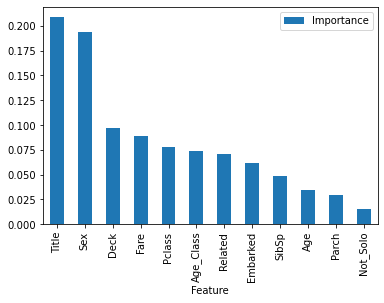

In [48]:
importances.plot.bar()

### Confusion Matrix, Precision, Recall, and F1 Score

Precision: 79.34%
Recall: 70.76%
F1 Score:  74.81%


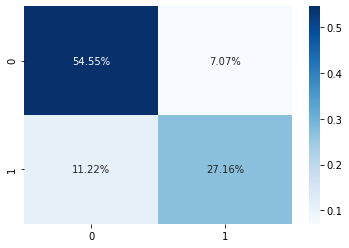

In [53]:
pred = cross_val_predict(clf, X_tr, y_tr, cv=3)
cf_matrix = confusion_matrix(y_tr, pred)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')
print(f"Precision: {precision_score(y_tr, pred) :.2%}")
print(f"Recall: {recall_score(y_tr, pred) :.2%}")
print(f"F1 Score: {f1_score(y_tr, pred) : .2%}")
fig 

### ROC AUC Curve

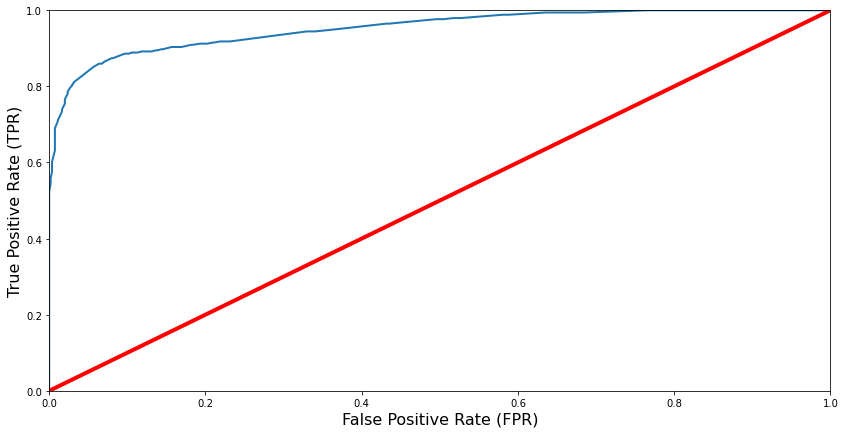

<Figure size 432x288 with 0 Axes>

In [57]:
# compute true positive rate and false positive rate
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_tr, y_scores)
# plotting them against each other
def plot_roc_curve(false_positive_rate, true_positive_rate, label=None):
    plt.plot(false_positive_rate, true_positive_rate, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'r', linewidth=4)
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (FPR)', fontsize=16)
    plt.ylabel('True Positive Rate (TPR)', fontsize=16)

plt.figure(figsize=(14, 7))
plot_roc_curve(false_positive_rate, true_positive_rate)
plt.show()
plt.savefig('roc_auc_curve.png')

### ROC AUC Score

In [66]:
r_a_score = roc_auc_score(y_tr, y_scores)
print("ROC AUC Score:", r_a_score)

ROC-AUC-Score: 0.9301334696790549
